In [1]:
import sys
import os

ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(os.path.abspath(ROOT))

In [2]:
from voxel_world.frame_loader import get_pointcloud, get_origin, get_radar_velocities
from voxel_world.pc_processing import generate_freespace_pointcloud, generate_voxel_array_dense, voxel_matrix_to_coords, get_freespace_matrix, generate_velocity_voxels, velocity_voxel_matrix_to_coords

import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt
import k3d

In [3]:
frame_number = 10
start_frame = 10
end_frame = 100

frame_str = f"{int(frame_number):05d}"
pc_radar = get_pointcloud(frame_str, reference_frame="map", sensor="radar")
sensor_origin_radar = get_origin("radar", "map", frame_str)
velocity_vectors = get_radar_velocities(frame_str, "map")

In [4]:
print(pc_radar.shape)
print(velocity_vectors.shape)

(341, 4)
(341, 3)


In [5]:
auto_frame = True
grid_visible = False

plot = k3d.plot(camera_auto_fit=auto_frame, axes_helper=0.0, grid_visible=grid_visible)

#Radar-Points:
plot += k3d.points(positions=np.asarray(pc_radar[:, :3], dtype=float), point_size=0.5)

#Velocities
plot += k3d.vectors(origins=np.asarray(pc_radar[:, :3], dtype=float), vectors=velocity_vectors)

plot.display()


c:\Users\leopo\anaconda3\envs\demons-env\lib\site-packages\traittypes\traittypes.py:101: UserWarning: Given trait value dtype "float64" does not match required type "float32". A coerced copy has been created.
  np.dtype(self.dtype).name))


Output()

In [6]:
def threshold_vectors(vectors, min_length, max_length):
    """
    Set vectors with lengths outside [min_length, max_length] to zero.
    
    Args:
        vectors: Nx3 numpy array of 3D vectors
        min_length: minimum allowed vector length
        max_length: maximum allowed vector length
    
    Returns:
        Modified array with thresholded vectors set to zero
    """
    # Compute squared lengths (avoids sqrt operation)
    sq_lengths = np.sum(vectors**2, axis=1)
    
    # Create mask for vectors outside the threshold
    mask = (sq_lengths < min_length**2) | (sq_lengths > max_length**2)
    
    # Apply mask (set invalid vectors to zero)
    vectors[mask] = 0
    
    return vectors

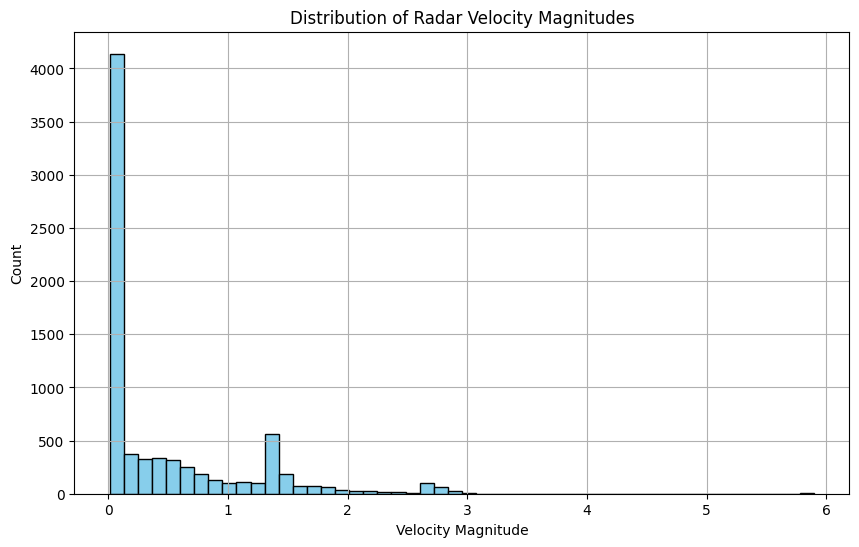

In [7]:

import matplotlib.pyplot as plt

# List to store all velocity magnitudes
velocity_magnitudes = []

for frame_number in range(start_frame, end_frame + 1):
    frame_str = f"{int(frame_number):05d}"
    pc_radar = get_pointcloud(frame_str, reference_frame="map", sensor="radar")
    sensor_origin_radar = get_origin("radar", "map", frame_str)
    velocity_vectors = get_radar_velocities(frame_str, "map")  # shape: (N, 3) or (N, 2)
    thresholded = threshold_vectors(velocity_vectors, 0.01, 10.0)

    # Compute magnitude (assuming each vector is a 2D or 3D vector)
    for v in thresholded:
        magnitude = np.linalg.norm(v)
        if magnitude > 0.0:
            velocity_magnitudes.append(magnitude)

# Convert to numpy array for convenience
velocity_magnitudes = np.array(velocity_magnitudes)

# Create histogram (bar plot)
counts, bin_edges = np.histogram(velocity_magnitudes, bins=50)  # adjust bins as needed
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

plt.figure(figsize=(10, 6))
plt.bar(bin_centers, counts, width=np.diff(bin_edges), color='skyblue', edgecolor='black')
plt.xlabel('Velocity Magnitude')
plt.ylabel('Count')
plt.title('Distribution of Radar Velocity Magnitudes')
plt.grid(True)
plt.show()
